In [119]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score, learning_curve, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, make_scorer
from scipy.stats import shapiro, ttest_rel, mannwhitneyu

In [120]:
serie = pd.read_csv("../data/unified_cluster_series_with_clipped3.csv", parse_dates=["end_timestamp"], index_col="end_timestamp")

In [121]:
umbral = serie["volume"].quantile(0.90)
y = serie["volume"]
picks = (serie["volume"] > umbral).astype(int)

# Crear features sin incluir "volume" (para evitar data leakage)
X = pd.DataFrame(serie)
X = X.drop(columns=["volume"])  # ← IMPORTANTE: Eliminar el target de las features
X = X.dropna()
picks = picks.loc[X.index]
y = y.loc[X.index]

Se entrenarán modelos de predicción con el objetivo de escoger el mejor. Con este fin se hará uso del framework de automl que se dispone en este repositorio. 

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [123]:
kf = TimeSeriesSplit(n_splits=30)
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

rf = RandomForestRegressor(
    n_estimators=158, max_depth=10, min_samples_split=6,
    min_samples_leaf=1, max_features=None, random_state=42
)
knn = KNeighborsRegressor(n_neighbors=7, weights="uniform", p=2)

scores_rf = cross_val_score(rf, X_train, y_train, cv=kf, scoring=scorer)
scores_knn = cross_val_score(knn, X_train, y_train, cv=kf, scoring=scorer)

rf_mean, rf_std = -scores_rf.mean(), scores_rf.std()
knn_mean, knn_std = -scores_knn.mean(), scores_knn.std()

print("Random Forest MAE promedio:", rf_mean, "±", rf_std)
print("KNN MAE promedio:", knn_mean, "±", knn_std)

Random Forest MAE promedio: 328632338.47674644 ± 326070529.7540322
KNN MAE promedio: 226053592.13333336 ± 263157234.73491463


In [124]:
shapiro_rf = shapiro(scores_rf)
shapiro_knn = shapiro(scores_knn)
print(f"\nShapiro-Wilk RF p-value: {shapiro_rf.pvalue:.3f}")
print(f"Shapiro-Wilk KNN p-value: {shapiro_knn.pvalue:.3f}")


Shapiro-Wilk RF p-value: 0.000
Shapiro-Wilk KNN p-value: 0.000


In [125]:
if shapiro_rf.pvalue > 0.05 and shapiro_knn.pvalue > 0.05:
    stat, pval = ttest_rel(scores_rf, scores_knn)
    print(f"\nt-Student: statistic={stat:.3f}, p-value={pval:.3f}")
else:
    stat, pval = mannwhitneyu(scores_rf, scores_knn)
    print(f"\nMann-Whitney: statistic={stat:.3f}, p-value={pval:.3f}")


Mann-Whitney: statistic=314.000, p-value=0.045


In [126]:
if pval < 0.05:
    best_model = rf if rf_mean < knn_mean else knn
    best_scores = scores_rf if rf_mean < knn_mean else scores_knn
    best_name = "Random Forest" if rf_mean < knn_mean else "KNN"
else:
    best_model = knn
    best_scores = knn
    best_name = "KNN (modelo más simple)"

print(f"\nModelo seleccionado: {best_name}")


Modelo seleccionado: KNN


In [127]:
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
print(f"MAE en test: {test_mae:.3f}")

MAE en test: 134829596.956


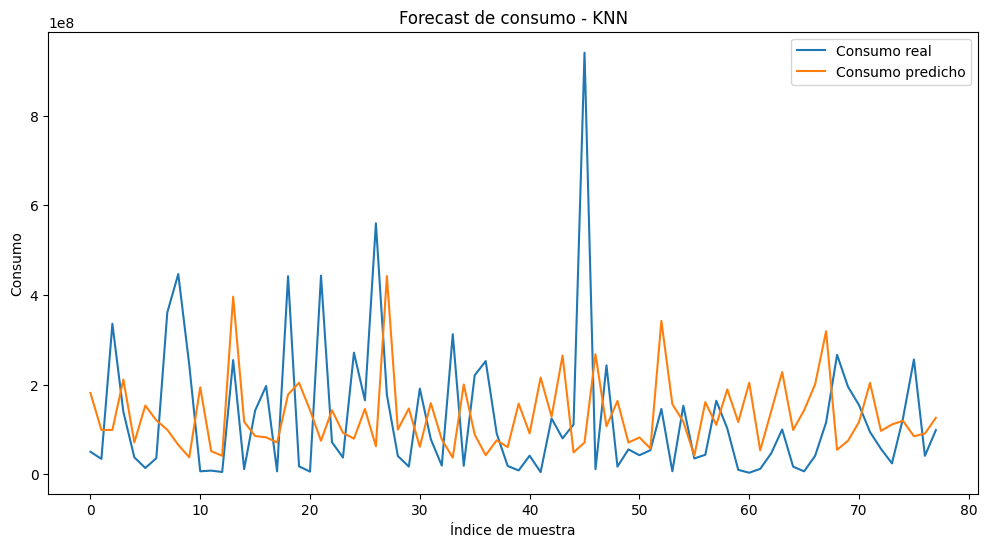

In [128]:
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label="Consumo real")
plt.plot(y_pred, label="Consumo predicho")
plt.title(f"Forecast de consumo - {best_name}")
plt.xlabel("Índice de muestra")
plt.ylabel("Consumo")
plt.legend()
plt.show()

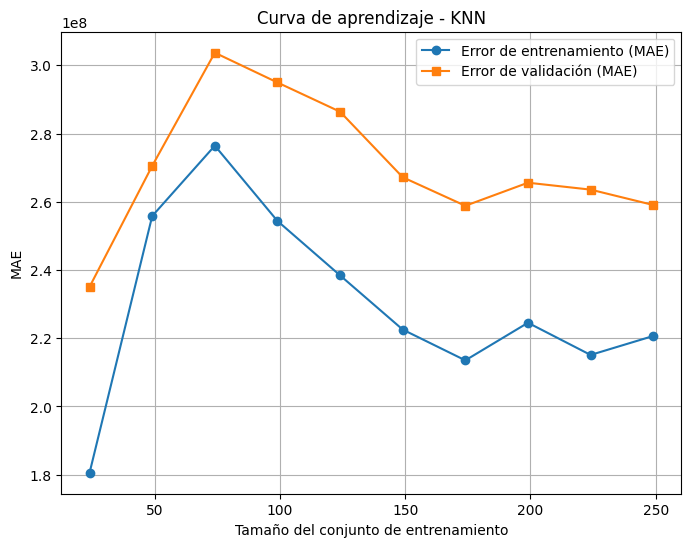

In [129]:
train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_train, y_train,
    cv=5,
    scoring="neg_mean_absolute_error",
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42
)

train_mae = -train_scores.mean(axis=1)
val_mae = -val_scores.mean(axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mae, label="Error de entrenamiento (MAE)", marker="o")
plt.plot(train_sizes, val_mae, label="Error de validación (MAE)", marker="s")
plt.title(f"Curva de aprendizaje - {best_name}")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("MAE")
plt.legend()
plt.grid(True)
plt.show()

# Prueba de hipótesis sobre la variable `peak`

## Objetivo
Evaluar si añadir la variable binaria `peak` como característica mejora el rendimiento del modelo (medido por MAE) respecto al mejor MAE actual: **226,053,592.13**.

## Hipótesis
- **Hipótesis nula (H₀):**  
  MAE_nuevo ≥ 226053592.13

- **Hipótesis alternativa (H₁):**  
  MAE_nuevo < 226053592.13

## Nivel de confianza
- 90%, lo que implica un nivel de significancia de α = 0.10.

## Criterio de decisión
- Si el **p-valor < 0.10**, se rechaza H₀ y se concluye que añadir `peak` mejora el modelo.
- Si el **p-valor ≥ 0.10**, no hay evidencia suficiente para afirmar que mejora significativamente.

### Enfoque 1 (umbral)

In [130]:
umbral = serie["volume"].quantile(0.90)
serie["peak"] = (serie["volume"] > umbral).astype(int)
serie.to_csv("../data/unified_cluster_series_with_peaks.csv")

In [131]:
# Crear features sin incluir "volume" (para evitar data leakage)
X = pd.DataFrame(serie)
X = X.drop(columns=["volume"])  # ← IMPORTANTE: Eliminar el target de las features
X = X.dropna()
y = serie["volume"]
y = y.loc[X.index]

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [133]:
kf = TimeSeriesSplit(n_splits=30)
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

rf = RandomForestRegressor(
    n_estimators=55, max_depth=None, min_samples_split=3, 
    min_samples_leaf=2, max_features=None
) 
knn = KNeighborsRegressor(n_neighbors=7, weights="uniform", p=2)

scores_rf = cross_val_score(rf, X_train, y_train, cv=kf, scoring=scorer)
scores_knn = cross_val_score(knn, X_train, y_train, cv=kf, scoring=scorer)

rf_mean, rf_std = -scores_rf.mean(), scores_rf.std()
knn_mean, knn_std = -scores_knn.mean(), scores_knn.std()

print("Random Forest MAE promedio:", rf_mean, "±", rf_std)
print("KNN MAE promedio:", knn_mean, "±", knn_std)

Random Forest MAE promedio: 192944309.12297222 ± 265973190.97692135
KNN MAE promedio: 226053592.13333336 ± 263157234.73491463


In [134]:
shapiro_rf = shapiro(scores_rf)
shapiro_knn = shapiro(scores_knn)
print(f"\nShapiro-Wilk RF p-value: {shapiro_rf.pvalue:.3f}")
print(f"Shapiro-Wilk KNN p-value: {shapiro_knn.pvalue:.3f}")


Shapiro-Wilk RF p-value: 0.000
Shapiro-Wilk KNN p-value: 0.000


In [135]:
if shapiro_rf.pvalue > 0.05 and shapiro_knn.pvalue > 0.05:
    stat, pval = ttest_rel(scores_rf, scores_knn)
    print(f"\nt-Student: statistic={stat:.3f}, p-value={pval:.3f}")
else:
    stat, pval = mannwhitneyu(scores_rf, scores_knn)
    print(f"\nMann-Whitney: statistic={stat:.3f}, p-value={pval:.3f}")


Mann-Whitney: statistic=599.000, p-value=0.028


In [136]:
if pval < 0.05:
    best_model = rf if rf_mean < knn_mean else knn
    new_best_scores = scores_rf if rf_mean < knn_mean else scores_knn
    best_name = "Random Forest" if rf_mean < knn_mean else "KNN"
else:
    best_model = knn
    new_best_scores = scores_knn
    best_name = "KNN (modelo más simple)"

print(f"\nModelo seleccionado: {best_name}")


Modelo seleccionado: Random Forest


In [137]:
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
print(f"MAE en test: {test_mae:.3f}")

MAE en test: 107769772.262


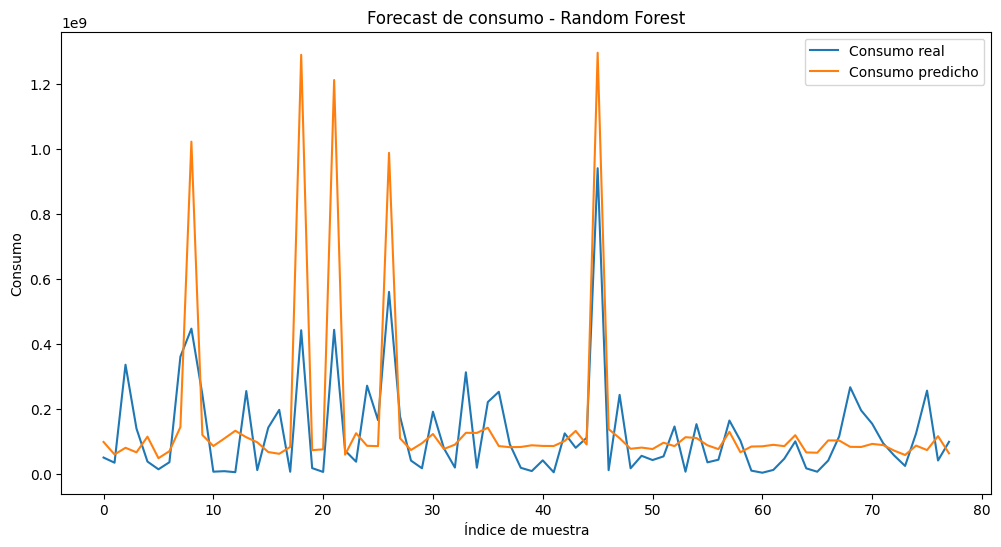

In [138]:
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label="Consumo real")
plt.plot(y_pred, label="Consumo predicho")
plt.title(f"Forecast de consumo - {best_name}")
plt.xlabel("Índice de muestra")
plt.ylabel("Consumo")
plt.legend()
plt.show()

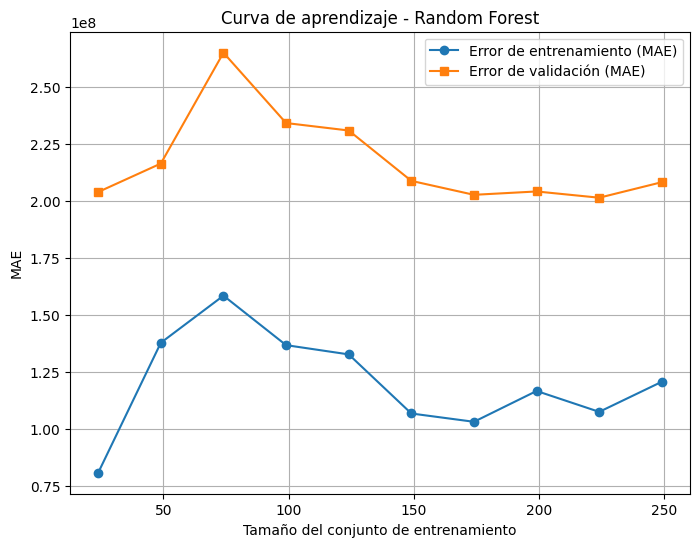

In [139]:
train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_train, y_train,
    cv=5,
    scoring="neg_mean_absolute_error",
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42
)

train_mae = -train_scores.mean(axis=1)
val_mae = -val_scores.mean(axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mae, label="Error de entrenamiento (MAE)", marker="o")
plt.plot(train_sizes, val_mae, label="Error de validación (MAE)", marker="s")
plt.title(f"Curva de aprendizaje - {best_name}")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("MAE")
plt.legend()
plt.grid(True)
plt.show()

In [140]:
shapiro_best = shapiro(best_scores)
shapiro_new_best = shapiro(new_best_scores)
print(f"\nShapiro-Wilk RF p-value: {shapiro_rf.pvalue:.3f}")
print(f"Shapiro-Wilk KNN p-value: {shapiro_knn.pvalue:.3f}")


Shapiro-Wilk RF p-value: 0.000
Shapiro-Wilk KNN p-value: 0.000


In [141]:
if shapiro_rf.pvalue > 0.05 and shapiro_knn.pvalue > 0.05:
    stat, pval = ttest_rel(best_scores, new_best_scores)
    print(f"\nt-Student: statistic={stat:.3f}, p-value={pval:.3f}")
else:
    stat, pval = mannwhitneyu(best_scores, new_best_scores)
    print(f"\nMann-Whitney: statistic={stat:.3f}, p-value={pval:.3f}")


Mann-Whitney: statistic=301.000, p-value=0.028


In [142]:
if shapiro_rf.pvalue > 0.05 and shapiro_knn.pvalue > 0.05:
    stat, pval = ttest_rel(best_scores, new_best_scores)
    print(f"\nt-Student: statistic={stat:.3f}, p-value={pval:.3f}")
else:
    stat, pval = mannwhitneyu(best_scores, new_best_scores)
    print(f"\nMann-Whitney: statistic={stat:.3f}, p-value={pval:.3f}")


Mann-Whitney: statistic=301.000, p-value=0.028


In [143]:
if pval < 0.1:
    print("Se rechaza H0")
else:
    print("No se puede rechazar H0")

Se rechaza H0


### Enfoque 2 (DBSCAN)

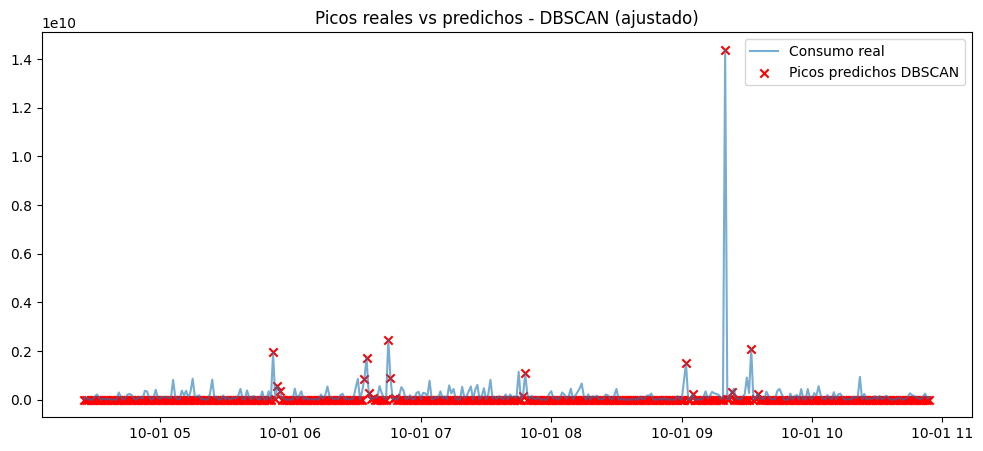

In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report

# =========================
# 2. Features históricos
# =========================
serie = pd.read_csv("../data/unified_cluster_series_with_clipped3.csv", parse_dates=["end_timestamp"], index_col="end_timestamp")

for lag in range(1, 4):
    serie[f"lag_{lag}"] = serie["volume"].shift(lag)

serie["rolling_mean3"] = serie["volume"].rolling(3).mean()
serie["rolling_std3"] = serie["volume"].rolling(3).std()
serie = serie.dropna()

X = serie[["lag_1","lag_2", "lag_3","rolling_mean3","rolling_std3"]]
serie = serie.drop(columns=["lag_1","lag_2", "lag_3","rolling_mean3","rolling_std3"])

# =========================
# 3. DBSCAN como detector de outliers
# =========================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

db = DBSCAN(eps=0.5, min_samples=10).fit(X_scaled)
labels = db.labels_

serie.loc[X.index, "pico_dbscan"] = (labels == -1).astype(int)

# Visualización de picos reales vs predichos (DBSCAN)
plt.figure(figsize=(12,5))
plt.plot(serie["volume"], label="Consumo real", alpha=0.6)
# Picos predichos por DBSCAN
plt.scatter(serie.index, serie["pico_dbscan"] * serie["volume"],
            color="red", marker="x", label="Picos predichos DBSCAN")
plt.legend()
plt.title("Picos reales vs predichos - DBSCAN (ajustado)")
plt.show()

In [145]:
serie.to_csv("../data/unified_cluster_series_with_dbscan_peaks.csv")

# Crear features sin incluir "volume" (para evitar data leakage)
X = pd.DataFrame(serie)
X = X.drop(columns=["volume"])  # ← IMPORTANTE: Eliminar el target de las features
X = X.dropna()
y = serie["volume"]
y = y.loc[X.index]

In [146]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [147]:
kf = TimeSeriesSplit(n_splits=30)
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

rf = RandomForestRegressor(
    n_estimators=55, max_depth=None, min_samples_split=3, 
    min_samples_leaf=2, max_features=None
) 
knn = KNeighborsRegressor(n_neighbors=7, weights="uniform", p=2)

scores_rf = cross_val_score(rf, X_train, y_train, cv=kf, scoring=scorer)
scores_knn = cross_val_score(knn, X_train, y_train, cv=kf, scoring=scorer)

rf_mean, rf_std = -scores_rf.mean(), scores_rf.std()
knn_mean, knn_std = -scores_knn.mean(), scores_knn.std()

print("Random Forest MAE promedio:", rf_mean, "±", rf_std)
print("KNN MAE promedio:", knn_mean, "±", knn_std)

Random Forest MAE promedio: 278825845.39585423 ± 301847879.19745404
KNN MAE promedio: 226053592.13333336 ± 263157234.73491463


In [148]:
shapiro_rf = shapiro(scores_rf)
shapiro_knn = shapiro(scores_knn)
print(f"\nShapiro-Wilk RF p-value: {shapiro_rf.pvalue:.3f}")
print(f"Shapiro-Wilk KNN p-value: {shapiro_knn.pvalue:.3f}")


Shapiro-Wilk RF p-value: 0.000
Shapiro-Wilk KNN p-value: 0.000


In [149]:
if shapiro_rf.pvalue > 0.05 and shapiro_knn.pvalue > 0.05:
    stat, pval = ttest_rel(scores_rf, scores_knn)
    print(f"\nt-Student: statistic={stat:.3f}, p-value={pval:.3f}")
else:
    stat, pval = mannwhitneyu(scores_rf, scores_knn)
    print(f"\nMann-Whitney: statistic={stat:.3f}, p-value={pval:.3f}")


Mann-Whitney: statistic=365.000, p-value=0.212


In [150]:
if pval < 0.05:
    best_model = rf if rf_mean < knn_mean else knn
    new_best_scores = scores_rf if rf_mean < knn_mean else scores_knn
    best_name = "Random Forest" if rf_mean < knn_mean else "KNN"
else:
    best_model = knn
    new_best_scores = scores_knn
    best_name = "KNN (modelo más simple)"

print(f"\nModelo seleccionado: {best_name}")


Modelo seleccionado: KNN (modelo más simple)


In [151]:
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
print(f"MAE en test: {test_mae:.3f}")

MAE en test: 134829596.956


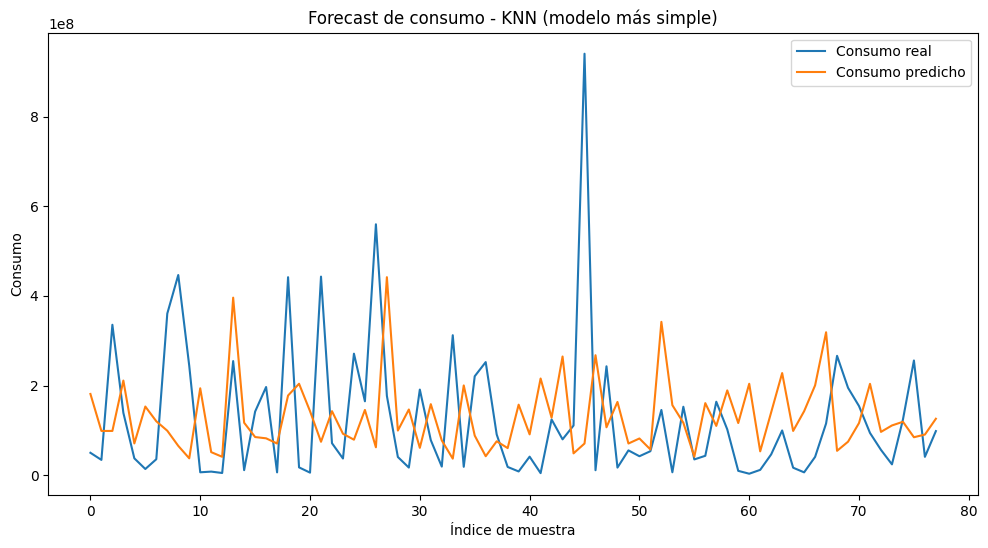

In [152]:
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label="Consumo real")
plt.plot(y_pred, label="Consumo predicho")
plt.title(f"Forecast de consumo - {best_name}")
plt.xlabel("Índice de muestra")
plt.ylabel("Consumo")
plt.legend()
plt.show()

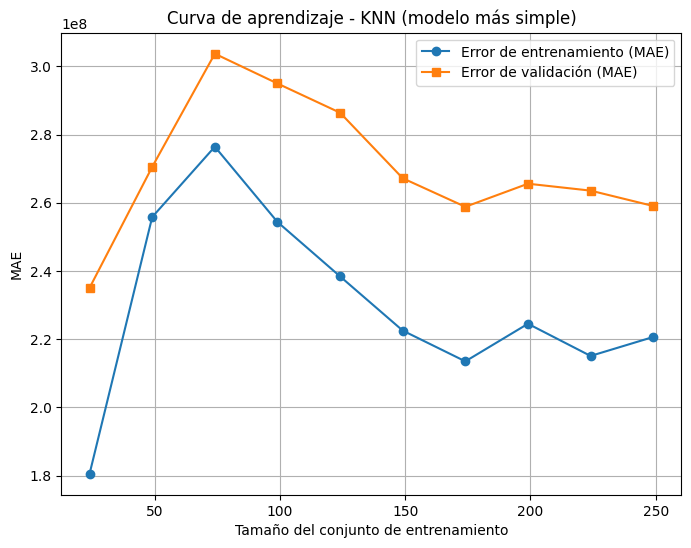

In [153]:
train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_train, y_train,
    cv=5,
    scoring="neg_mean_absolute_error",
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42
)

train_mae = -train_scores.mean(axis=1)
val_mae = -val_scores.mean(axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mae, label="Error de entrenamiento (MAE)", marker="o")
plt.plot(train_sizes, val_mae, label="Error de validación (MAE)", marker="s")
plt.title(f"Curva de aprendizaje - {best_name}")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("MAE")
plt.legend()
plt.grid(True)
plt.show()

In [154]:
shapiro_best = shapiro(best_scores)
shapiro_new_best = shapiro(new_best_scores)
print(f"\nShapiro-Wilk RF p-value: {shapiro_rf.pvalue:.3f}")
print(f"Shapiro-Wilk KNN p-value: {shapiro_knn.pvalue:.3f}")


Shapiro-Wilk RF p-value: 0.000
Shapiro-Wilk KNN p-value: 0.000


In [155]:
if shapiro_rf.pvalue > 0.05 and shapiro_knn.pvalue > 0.05:
    stat, pval = ttest_rel(best_scores, new_best_scores)
    print(f"\nt-Student: statistic={stat:.3f}, p-value={pval:.3f}")
else:
    stat, pval = mannwhitneyu(best_scores, new_best_scores)
    print(f"\nMann-Whitney: statistic={stat:.3f}, p-value={pval:.3f}")


Mann-Whitney: statistic=450.000, p-value=1.000


In [156]:
if shapiro_rf.pvalue > 0.05 and shapiro_knn.pvalue > 0.05:
    stat, pval = ttest_rel(best_scores, new_best_scores)
    print(f"\nt-Student: statistic={stat:.3f}, p-value={pval:.3f}")
else:
    stat, pval = mannwhitneyu(best_scores, new_best_scores)
    print(f"\nMann-Whitney: statistic={stat:.3f}, p-value={pval:.3f}")


Mann-Whitney: statistic=450.000, p-value=1.000


In [157]:
if pval < 0.1:
    print("Se rechaza H0")
else:
    print("No se puede rechazar H0")

No se puede rechazar H0


### Conclusiones

Se presentaron dos enfoques de clasificación de picos:

- Con un umbral establecido 
- Con detección de outliers con DBSCAN (outlier == pico)

Para el primer enfoque se rechaza la hipótesis nula y se obtuvo una mejora en el error. El error promedio bajó de cerca de 230MB a 190MB.

Sin embargo, para el segundo enfoque no hubo evidencias suficientes para rechazar la hipótesis nula por tanto se mantiene el agrego del feature de "pico o no" con el criterio de mayor que un umbral.